# 01_experiments_dev — MVTec 画像異常検知（開発

本ノートは dev カテゴリのみで設計を確定し、固定パイプライン設定を `assets/fixed_pipeline.json` に出力するためのテンプレートです。
- データ取得は anomalib を用いる（AGENTS.md 準拠）
- 手法は Mahalanobis / PaDiM を比較
- 閾値は dev の test で画像レベル FPR=1% を目標に決定

実行順序：Header → Data → Methods → Results → Save JSON/Artifacts


## 環境・依存の読み込み

In [24]:
import os
from pathlib import Path
import json
import numpy as np
import pandas as pd
import torch
from torchvision import models, transforms
from sklearn.covariance import ledoit_wolf
from sklearn.metrics import roc_auc_score, f1_score
import matplotlib.pyplot as plt
import plotly.express as px
from torch import nn
import torch.nn.functional as F
import random
import warnings

# anomaly_detectors からコア関数をインポート
from anomaly_detectors import (
    fit_mahalanobis, all_mahalanobis_scores,
    fit_padim, padim_heatmap, all_padim_scores,
)

## データ取得（anomalib 経由）

In [25]:
# 既存の MVTEC_ROOT または datasets/MVTecAD を使用。
# 未検出の場合は anomalib によりダウンロード。
MVTEC_ROOT = Path(os.environ.get("MVTEC_ROOT", "datasets/MVTecAD"))
MVTEC_ROOT.mkdir(parents=True, exist_ok=True)

# anomalib のAPIはバージョンで異なる可能性があるため、例示的に記述。
# 実環境の anomalib バージョンに合わせて import と引数を調整してください。
try:
    from anomalib.data import MVTecAD
    datamodule = MVTecAD(root=str(MVTEC_ROOT))
    datamodule.prepare_data()  # download if needed
    datamodule.setup()
except Exception as e:
    print("[WARN] anomalib のデータ取得セットアップで問題が発生しました。バージョンや引数を確認してください:\n", e)

assert MVTEC_ROOT.exists(), "MVTec root not found after anomalib setup."


## 実験設定

In [26]:
# torchvision のモデル名から学習済みモデルを読み込む関数
def load_backbone_from_name(name: str):
    try:
        from torchvision.models import get_model, get_model_weights
        weights = None
        try:
            weights = get_model_weights(name).DEFAULT  # 学習済みウェイト
        except Exception:
            pass  # ウェイトが無いモデルはランダム初期化で作る
        return get_model(name, weights=weights).eval()
    except Exception:
        # 旧 API フォールバック（古い torchvision 向け）
        if not hasattr(models, name):
            raise ValueError(f"Unknown backbone name: {name}")
        return models.__dict__[name](pretrained=True).eval()

In [27]:
# dev カテゴリを定義
dev_category = "carpet" 

# モデル本体インポート

backbone = "resnet18" # "efficientnet_b0"
model = load_backbone_from_name(backbone)

MD_layer = 'flatten' # resnet18、 efficientnet_b0 共通
padim_layers = ["layer1.1.relu_1", "layer2.1.relu_1", "layer3.1.relu_1"] # resnet18の場合
#padim_layers = ['features.6.3.add', 'features.7.0.block.0', 'features.7.0.block.1', 'features.7.0.block.2', 'features.7.0.block.3'] # efficientnet_b0の場合
EXPERIMENT_NAME = f"{backbone}"

# 共通設定
batch_size = 16
num_workers = min(4, os.cpu_count() or 1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_size = 256
threshold_percentile = 99
padim_channel_subsample = 100

## 学習と推論
- 各手法で dev の train を用いたクロスバリデーションを実施し、訓練内/訓練外スコアのヒストグラムを確認する。
- dev の test で閾値と評価指標（AUROC, F1 など）の関係を可視化する。


### データローダー準備

In [28]:
# Data loading for cross-validation (dev train) and dev test
# - Builds KFold train/val DataLoaders using only train/good images.
# - Prepares dev test DataLoader with labels (good=0, defect=1).

from pathlib import Path
from typing import List, Tuple, Any
from PIL import Image
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader, Subset
import os

# Transforms (ImageNet mean/std)
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

class ImagePathDataset(Dataset):
    """Minimal dataset returning (image_tensor, label).

    Paths: list of filesystem paths; Labels: list[Any] of same length.
    """
    def __init__(self, paths: List[Path], labels: List[Any], transform=None):
        self.paths = [Path(p) for p in paths]
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        y = self.labels[idx]
        img = Image.open(p).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img, y

def _existing_category_root(category: str) -> Path:
    """Find an existing MVTec category root among common layouts.
    Prefers MVTEC_ROOT, then 'datasets/MVTecAD', then 'MVtec_dataset'.
    """
    candidates = [
        MVTEC_ROOT / category,
        Path("datasets/MVTecAD") / category,
        Path("MVtec_dataset") / category,
    ]
    for c in candidates:
        if c.exists():
            return c
    raise FileNotFoundError(f"MVTec category not found: {category}")

def _list_images(d: Path) -> List[Path]:
    exts = {".png", ".jpg", ".jpeg"}
    if not d.exists():
        return []
    return sorted([p for p in d.rglob('*') if p.suffix.lower() in exts])

def build_cv_and_test_loaders(category: str, k_splits: int = 5, batch_size: int = 32) -> Tuple[list, DataLoader]:
    """Return (cv_folds, test_loader).

    cv_folds: list of dicts with 'train_loader' and 'val_loader'.
    test_loader: dev test DataLoader with labels equal to defect types
                 (the directory names directly under 'test', e.g., 'good',
                 'scratch', 'hole', ...).
    """
    root = _existing_category_root(category)
    train_good = _list_images(root / 'train' / 'good')
    assert len(train_good) > 0, f"No train/good images found for {category}"

    # Prepare KFold over indices (all labels are 0 in train).
    kf = KFold(n_splits=k_splits, shuffle=True, random_state=0)
    base_ds = ImagePathDataset(train_good, [0] * len(train_good), transform=_transform)

    num_workers = min(4, os.cpu_count() or 1)
    cv_folds = []
    for fold_id, (tr_idx, va_idx) in enumerate(kf.split(range(len(train_good)))):
        tr_ds = Subset(base_ds, tr_idx)
        va_ds = Subset(base_ds, va_idx)
        tr_loader = DataLoader(tr_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
        va_loader = DataLoader(va_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
        cv_folds.append({
            'fold': fold_id,
            'train_loader': tr_loader,
            'val_loader': va_loader,
            'n_train': len(tr_idx),
            'n_val': len(va_idx),
        })

    # Build dev test loader with labels as defect types (dir names under 'test').
    test_dir = root / 'test'
    test_paths: List[Path] = []
    test_labels: List[str] = []
    if test_dir.exists():
        # Iterate over subdirectories directly under 'test' (including 'good').
        for sub in sorted([d for d in test_dir.iterdir() if d.is_dir()], key=lambda p: p.name):
            label = sub.name  # defect type (or 'good')
            paths = _list_images(sub)
            if paths:
                test_paths.extend(paths)
                test_labels.extend([label] * len(paths))
    assert len(test_paths) > 0, f"No test images found for {category}"

    test_ds = ImagePathDataset(test_paths, test_labels, transform=_transform)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    return cv_folds, test_loader

# Build loaders for the chosen dev category
cv_folds, dev_test_loader = build_cv_and_test_loaders(dev_category, k_splits=5, batch_size=32)
print(f"[INFO] Category: {dev_category}")
print(f"[INFO] CV folds: {len(cv_folds)}")
for f in cv_folds:
    print(f"  - fold {f['fold']}: n_train={f['n_train']}, n_val={f['n_val']}")
from collections import Counter
cnt = Counter(dev_test_loader.dataset.labels)
print(f"[INFO] Dev test size: {len(dev_test_loader.dataset)}")
print(f"[INFO] Test label distribution: {dict(cnt)}")


[INFO] Category: carpet
[INFO] CV folds: 5
  - fold 0: n_train=224, n_val=56
  - fold 1: n_train=224, n_val=56
  - fold 2: n_train=224, n_val=56
  - fold 3: n_train=224, n_val=56
  - fold 4: n_train=224, n_val=56
[INFO] Dev test size: 117
[INFO] Test label distribution: {'color': 19, 'cut': 17, 'good': 28, 'hole': 17, 'metal_contamination': 17, 'thread': 19}


In [29]:
from datetime import datetime
from pathlib import Path
import json
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import plotly.express as px
ts = datetime.now().strftime('%Y%m%d%H%M')
base_dir = Path(f'results/dev/{ts}_{EXPERIMENT_NAME}')
dir_md = base_dir / 'MD'
dir_padim = base_dir / 'PaDiM'
dir_md.mkdir(parents=True, exist_ok=True); dir_padim.mkdir(parents=True, exist_ok=True)
print(f'[INFO] Results will be saved under: {base_dir}')


[INFO] Results will be saved under: results/dev/202509202201_resnet18


In [ ]:
def plot_histogram(df: pd.DataFrame, ifold: int, save_dir: Path, show_image=False):
    # スコアを対数変換
    df["log_score"] = np.log1p(df["score"])

    # ヒストグラムの描画（Matplotlib）
    fig, ax = plt.subplots(figsize=(8, 5))

    # 全データでビンを共有（Plotlyのnbins=30相当）
    n_bins = 30
    bin_edges = np.linspace(df["log_score"].min(), df["log_score"].max(), n_bins + 1)

    # 表示順を「train」「val」「good」（テストデータ）優先にし、残りは登場順で
    labels_all = df["label"].unique().tolist()
    ordered = ["train", "val", "good"] + [l for l in labels_all if l not in ("train", "val", "good")]

    for lb in ordered:
        vals = df.loc[df["label"] == lb, "log_score"].to_numpy()
        if len(vals) == 0:
            continue
        ax.hist(
            vals,
            bins=bin_edges,
            alpha=0.6,
            label=lb,
            edgecolor="black",
            linewidth=0.3,
        )

    ax.set_title(f"Anomaly Scores (Fold {ifold})")
    ax.set_xlabel("log_score")
    ax.set_ylabel("count")
    # ラベル数が多い場合の視認性配慮（必要に応じて調整）
    ax.legend(fontsize=8, ncol=2)
    fig.tight_layout()

    # 画面表示
    if show_image:
        plt.show()

    # 保存（PNG）
    out_png = save_dir / f"fold_{ifold}_hist.png"
    fig.savefig(out_png, dpi=150)
    print(f"[INFO] Saved histogram PNG: {out_png}")

    plt.close(fig)

### 異常検知実験の実行

In [ ]:
from dataclasses import dataclass
from typing import Any, Callable, Dict
from pathlib import Path


def _to_cpu(obj):
    if isinstance(obj, torch.Tensor):
        return obj.detach().cpu()
    if isinstance(obj, list):
        return [_to_cpu(o) for o in obj]
    if isinstance(obj, tuple):
        return tuple(_to_cpu(o) for o in obj)
    return obj


@dataclass
class MethodSpec:
    key: str
    display_name: str
    fit_fn: Callable[..., Any]
    score_fn: Callable[..., Any]
    fit_kwargs: Dict[str, Any]
    score_kwargs_common: Dict[str, Any]
    score_kwargs_test: Dict[str, Any]
    output_dir: Path
    collects_heatmaps: bool = False


def run_pipeline(
    spec: MethodSpec,
    model,
    device,
    *,
    category: str,
    k_splits: int = 5,
    batch_size: int = 32,
    oof_percentile: float = 0.99,
    plot_histogram_fn=plot_histogram,
):
    # CV→OOF z閾値→最終モデル学習→最終評価を一括実行。
    spec.output_dir.mkdir(parents=True, exist_ok=True)

    # ローダー生成
    cv_folds, dev_test_loader = build_cv_and_test_loaders(
        category, k_splits=k_splits, batch_size=batch_size
    )

    # 全訓練のnormal onlyローダー（最終モデル用）
    def _build_full_train_loader_internal(category: str, batch_size: int = 32):
        root = _existing_category_root(category)
        train_good = _list_images(root / 'train' / 'good')
        assert len(train_good) > 0, f"No train/good images found for {category}"
        from torch.utils.data import DataLoader
        ds = ImagePathDataset(train_good, [0] * len(train_good), transform=_transform)
        num_workers = min(4, os.cpu_count() or 1)
        return DataLoader(
            ds, batch_size=batch_size, shuffle=False,
            num_workers=num_workers, pin_memory=True
        )

    fold_artifacts = {}
    metric_rows = []
    oof_normal_scores_per_fold = []

    test_labels = np.array(
        [0 if lbl == 'good' else 1 for lbl in dev_test_loader.dataset.labels]
    )

    # CV
    for ifold, fold in enumerate(cv_folds):
        fit_kwargs = dict(spec.fit_kwargs)
        fit_kwargs.setdefault('device', device)
        model_state = spec.fit_fn(
            fold['train_loader'],
            model,
            **fit_kwargs,
        )

        scores_train = _to_cpu(
            spec.score_fn(model_state, fold['train_loader'], **spec.score_kwargs_common)
        )
        scores_val = _to_cpu(
            spec.score_fn(model_state, fold['val_loader'], **spec.score_kwargs_common)
        )
        oof_normal_scores_per_fold.append(scores_val.numpy())

        test_out = spec.score_fn(
            model_state, dev_test_loader, **spec.score_kwargs_test
        )
        if spec.collects_heatmaps:
            scores_test, heatmaps_test = test_out
        else:
            scores_test, heatmaps_test = test_out, None
        scores_test = _to_cpu(scores_test)
        if heatmaps_test is not None:
            heatmaps_test = _to_cpu(heatmaps_test)

        fold_artifacts[ifold] = {
            'model_state': model_state,
            'scores_train': scores_train,
            'scores_val': scores_val,
            'scores_test': scores_test,
            'heatmaps_test': heatmaps_test,
        }

        # 監視用メトリクス
        scores_val_np = scores_val.numpy()
        scores_test_np = scores_test.numpy()
        fold_threshold = float(np.quantile(scores_val_np, oof_percentile))
        preds_test = (scores_test_np >= fold_threshold).astype(int)
        auc = roc_auc_score(test_labels, scores_test_np)
        f1 = f1_score(test_labels, preds_test)
        metric_rows.append({
            'fold': ifold,
            'threshold_raw@fold': fold_threshold,
            'auc': auc,
            'f1': f1,
        })

        df_hist = pd.DataFrame({
            'score': np.r_[
                scores_train.numpy(), scores_val.numpy(), scores_test.numpy()
            ],
            'label': (
                ['train'] * len(scores_train)
                + ['val'] * len(scores_val)
                + dev_test_loader.dataset.labels
            ),
        })
        plot_histogram_fn(df_hist, ifold, spec.output_dir)

        print(
            f"[{spec.display_name} Fold {ifold}] Raw-th@{int(oof_percentile*100)}%: {fold_threshold:.4f}, "
            f"AUC: {auc:.4f}, F1: {f1:.4f}"
        )

    metrics_df = pd.DataFrame(metric_rows)
    metrics_df.to_csv(spec.output_dir / 'summary.csv', index=False)
    auc_mean = float(metrics_df['auc'].mean())
    auc_std = float(metrics_df['auc'].std())
    f1_mean = float(metrics_df['f1'].mean())
    f1_std = float(metrics_df['f1'].std())

    print(
        f"[{spec.display_name}] CV AUC: {auc_mean:.4f} ± {auc_std:.4f}, "
        f"F1: {f1_mean:.4f} ± {f1_std:.4f}"
    )

    # OOF z閾値
    assert len(oof_normal_scores_per_fold) > 0, 'OOF scores are empty.'
    oof_normal_scores = np.concatenate(oof_normal_scores_per_fold)
    threshold_oof_raw = float(np.quantile(oof_normal_scores, oof_percentile))
    mu_oof = float(np.mean(oof_normal_scores))
    sigma_oof = float(np.std(oof_normal_scores, ddof=1))
    denom_oof = sigma_oof if sigma_oof > 0 else 1.0
    z_threshold = float(np.quantile((oof_normal_scores - mu_oof) / denom_oof, oof_percentile))

    print({
        'OOF_N': len(oof_normal_scores),
        'threshold_oof_raw': threshold_oof_raw,
        'mu_oof': mu_oof,
        'sigma_oof': sigma_oof,
        'z_threshold': z_threshold,
    })

    # 最終モデル
    final_train_loader_normal_only = _build_full_train_loader_internal(category, batch_size)

    final_fit_kwargs = dict(spec.fit_kwargs)
    final_fit_kwargs.setdefault('device', device)
    final_model_state = spec.fit_fn(
        final_train_loader_normal_only,
        model,
        **final_fit_kwargs,
    )

    final_train_normal_scores = _to_cpu(
        spec.score_fn(
            final_model_state,
            final_train_loader_normal_only,
            **spec.score_kwargs_common,
        )
    ).numpy()
    mu_final = float(np.mean(final_train_normal_scores))
    sigma_final = float(np.std(final_train_normal_scores, ddof=1))
    denom_final = sigma_final if sigma_final > 0 else 1.0

    final_out = spec.score_fn(
        final_model_state, dev_test_loader, **spec.score_kwargs_test
    )
    if spec.collects_heatmaps:
        final_test_scores, final_heatmaps_test = final_out
    else:
        final_test_scores, final_heatmaps_test = final_out, None

    final_test_scores = _to_cpu(final_test_scores).numpy()
    final_preds = ((final_test_scores - mu_final) / denom_final > z_threshold).astype(int)
    final_auc = float(roc_auc_score(test_labels, final_test_scores))
    final_f1 = float(f1_score(test_labels, final_preds))

    print(
        f"[{spec.display_name} Final] AUC: {final_auc:.4f}, F1(z@{int(oof_percentile*100)}%): {final_f1:.4f}"
    )

    return {
        'fold_artifacts': fold_artifacts,
        'metrics': metrics_df,
        'auc_mean': auc_mean,
        'auc_std': auc_std,
        'f1_mean': f1_mean,
        'f1_std': f1_std,
        'oof': {
            'oof_normal_scores_per_fold': oof_normal_scores_per_fold,
            'threshold_oof_raw': threshold_oof_raw,
            'mu_oof': mu_oof,
            'sigma_oof': sigma_oof,
            'z_threshold': z_threshold,
        },
        'final': {
            'model_state': final_model_state,
            'mu_final': mu_final,
            'sigma_final': sigma_final,
            'test_scores': final_test_scores,
            'preds': final_preds,
            'auc': final_auc,
            'f1': final_f1,
            'heatmaps_test': final_heatmaps_test,
        },
    }


/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


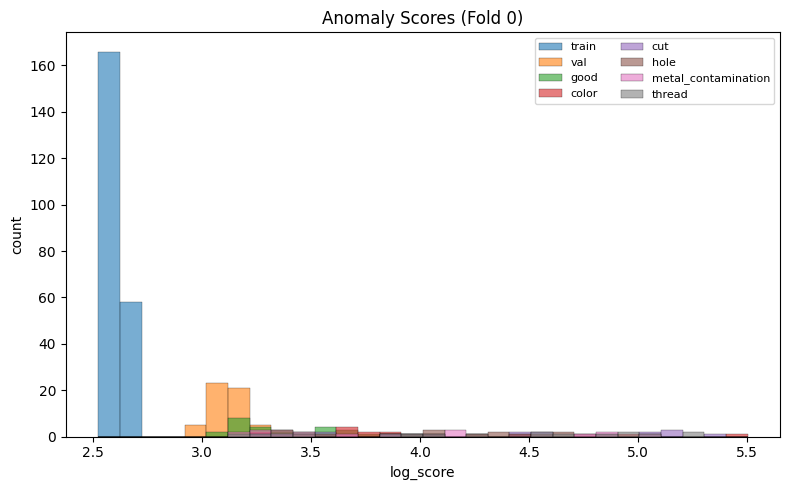

[INFO] Saved histogram PNG: results/dev/202509202201_resnet18/MD/fold_0_hist.png
[Mahalanobis Fold 0] Val threshold (FPR=1%): 27.4668, Test AUC: 0.8355, F1: 0.8343


/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


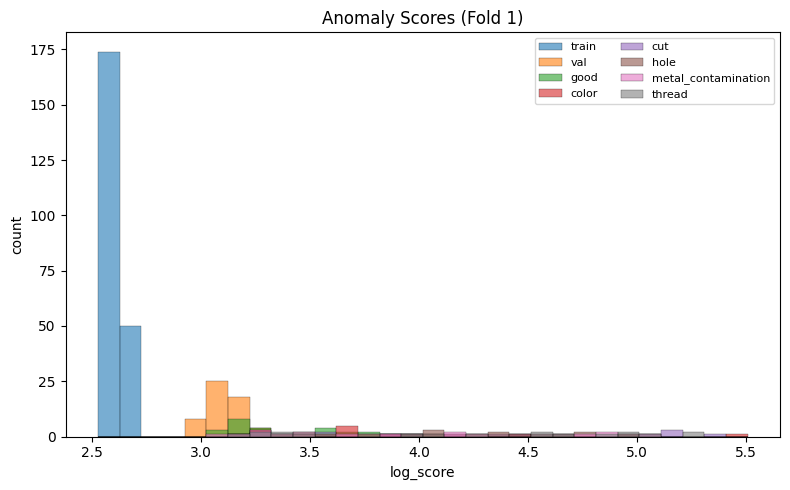

[INFO] Saved histogram PNG: results/dev/202509202201_resnet18/MD/fold_1_hist.png
[Mahalanobis Fold 1] Val threshold (FPR=1%): 27.2209, Test AUC: 0.8355, F1: 0.8343


/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


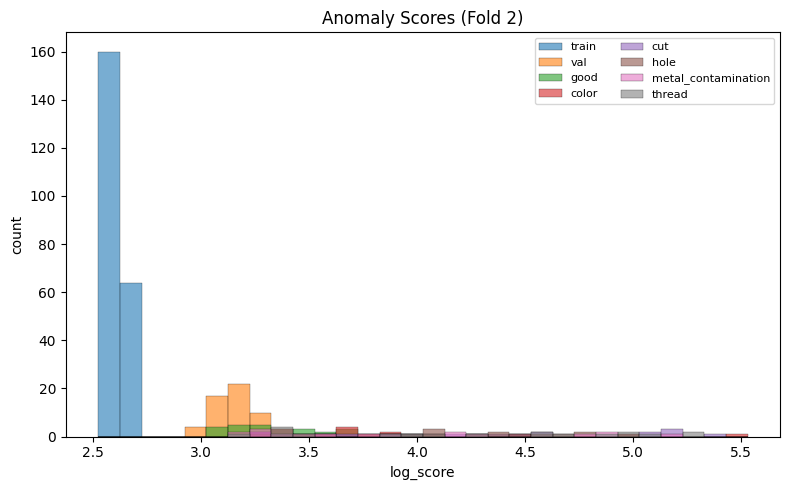

[INFO] Saved histogram PNG: results/dev/202509202201_resnet18/MD/fold_2_hist.png
[Mahalanobis Fold 2] Val threshold (FPR=1%): 31.9091, Test AUC: 0.8391, F1: 0.8024


/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


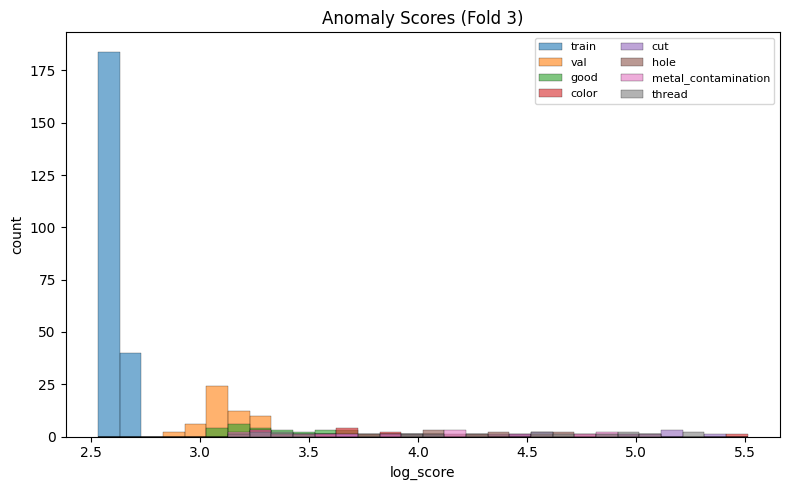

[INFO] Saved histogram PNG: results/dev/202509202201_resnet18/MD/fold_3_hist.png
[Mahalanobis Fold 3] Val threshold (FPR=1%): 31.7203, Test AUC: 0.8379, F1: 0.8024


/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


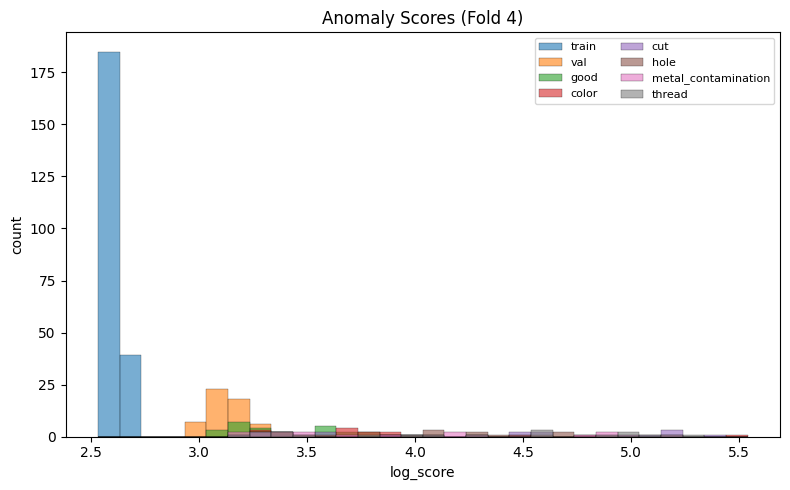

[INFO] Saved histogram PNG: results/dev/202509202201_resnet18/MD/fold_4_hist.png
[Mahalanobis Fold 4] Val threshold (FPR=1%): 28.4794, Test AUC: 0.8315, F1: 0.8324
[Mahalanobis] Test AUC: 0.8359 ± 0.0029, F1: 0.8211 ± 0.0171


/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


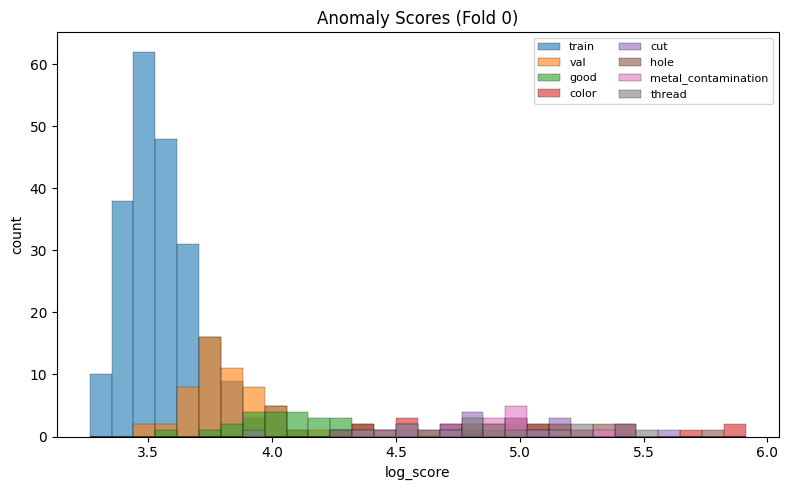

[INFO] Saved histogram PNG: results/dev/202509202201_resnet18/PaDiM/fold_0_hist.png
[PaDiM Fold 0] Val threshold (FPR=1%): 80.2876, Test AUC: 0.9430, F1: 0.9432


/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


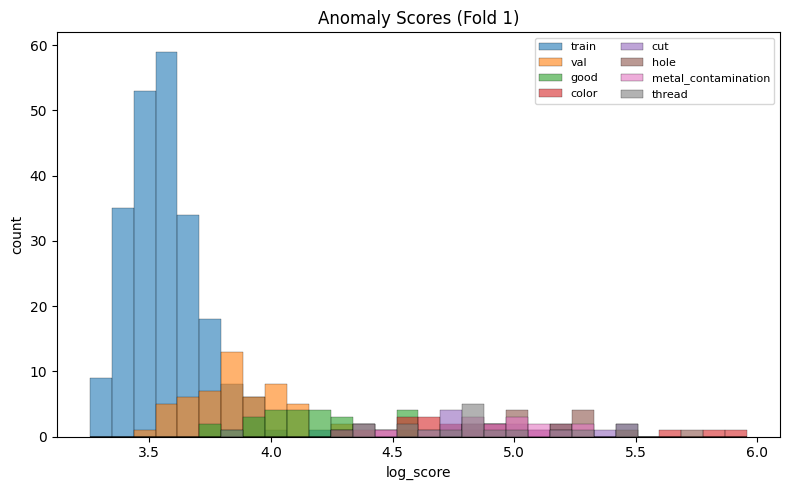

[INFO] Saved histogram PNG: results/dev/202509202201_resnet18/PaDiM/fold_1_hist.png
[PaDiM Fold 1] Val threshold (FPR=1%): 90.3524, Test AUC: 0.9506, F1: 0.9070


/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


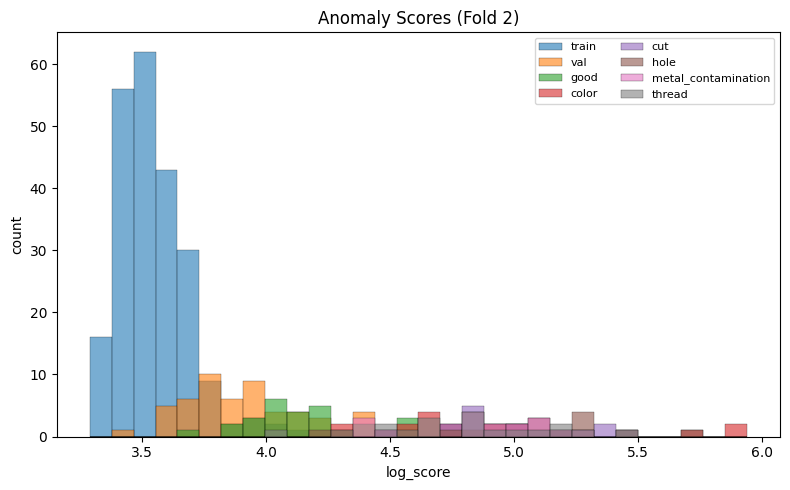

[INFO] Saved histogram PNG: results/dev/202509202201_resnet18/PaDiM/fold_2_hist.png
[PaDiM Fold 2] Val threshold (FPR=1%): 113.3250, Test AUC: 0.9494, F1: 0.8312


/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


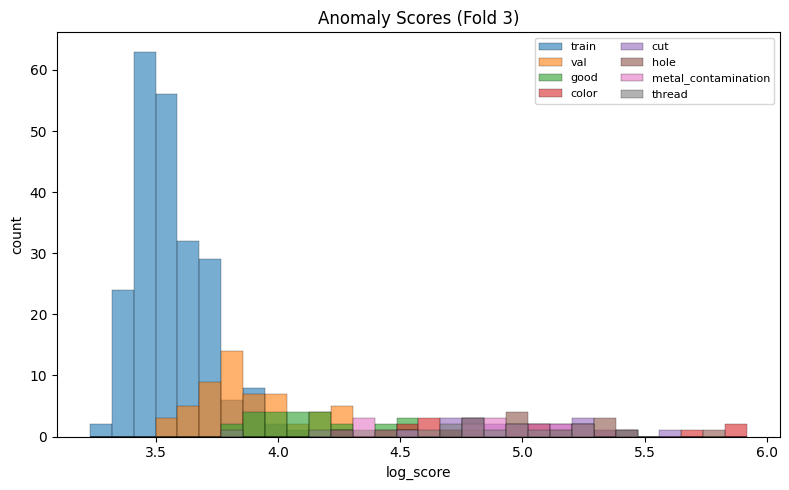

[INFO] Saved histogram PNG: results/dev/202509202201_resnet18/PaDiM/fold_3_hist.png
[PaDiM Fold 3] Val threshold (FPR=1%): 68.8588, Test AUC: 0.9430, F1: 0.9399


/home/sim_m/work/image-anomaly-detection/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


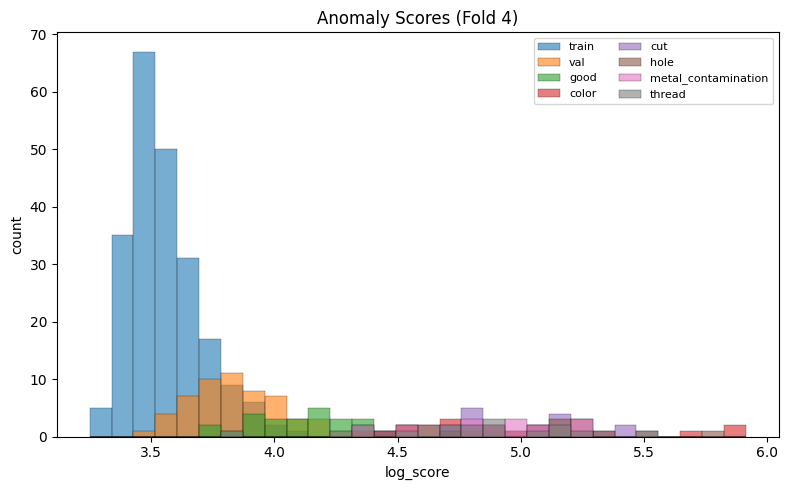

[INFO] Saved histogram PNG: results/dev/202509202201_resnet18/PaDiM/fold_4_hist.png
[PaDiM Fold 4] Val threshold (FPR=1%): 73.3449, Test AUC: 0.9539, F1: 0.9508
[PaDiM] Test AUC: 0.9480 ± 0.0048, F1: 0.9144 ± 0.0495


In [33]:
method_specs = [
    MethodSpec(
        key="mahalanobis",
        display_name="Mahalanobis",
        fit_fn=fit_mahalanobis,
        score_fn=all_mahalanobis_scores,
        fit_kwargs={"feature_node": MD_layer},
        score_kwargs_common={},
        score_kwargs_test={},
        output_dir=dir_md,
    ),
    MethodSpec(
        key="padim",
        display_name="PaDiM",
        fit_fn=fit_padim,
        score_fn=all_padim_scores,
        fit_kwargs={
            "layers": padim_layers,
            "d": padim_channel_subsample,
        },
        score_kwargs_common={},
        score_kwargs_test={"return_maps": True},
        output_dir=dir_padim,
        collects_heatmaps=True,
    ),
]

method_results = {}
for spec in method_specs:
    method_results[spec.key] = run_pipeline(
        spec=spec,
        model=model,
        device=device,
        category=dev_category,
        k_splits=5,
        batch_size=batch_size,
        oof_percentile=threshold_percentile / 100.0,
    )


In [35]:
# 結果表示（CVメトリクス）
display(method_results["mahalanobis"]["metrics"]) 
display(method_results["padim"]["metrics"]) 

# 最終モデルの指標
print({
    "Mahalanobis_final_auc": method_results["mahalanobis"]["final"]["auc"],
    "Mahalanobis_final_f1": method_results["mahalanobis"]["final"]["f1"],
    "PaDiM_final_auc": method_results["padim"]["final"]["auc"],
    "PaDiM_final_f1": method_results["padim"]["final"]["f1"],
})


,fold,threshold,auc,f1
0,0,27.466839,0.835474,0.834286
1,1,27.220857,0.835474,0.834286
2,2,31.909091,0.839085,0.802395
3,3,31.720325,0.837881,0.802395
4,4,28.479396,0.831461,0.832370


,fold,threshold,auc,f1
0,0,80.287638,0.943018,0.943182
1,1,90.352393,0.950642,0.906977
2,2,113.324950,0.949438,0.831169
3,3,68.858771,0.943018,0.939891
4,4,73.344926,0.953852,0.950820


#### PaDiMのヒートマップ表示

In [36]:
def inv_transform(img_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """正規化済み画像テンソルを逆変換してNumPy配列にする"""
    # バッチ次元がある場合は除去
    if img_tensor.dim() == 4:
        img = img_tensor.squeeze(0)
    else:
        img = img_tensor

    # テンソルを NumPy 配列に変換（形状は [3, H, W]）
    img_np = img.cpu().numpy()

    # 逆正規化: 各チャネルについて (x * std + mean)
    mean = np.array(mean)[:, None, None]
    std = np.array(std)[:, None, None]
    img_np = img_np * std + mean

    # 値を [0, 1] にクリップ
    img_np = np.clip(img_np, 0, 1)

    # 軸の順番を [3, H, W] → [H, W, 3] に変換
    img_np = np.transpose(img_np, (1, 2, 0))

    return img_np

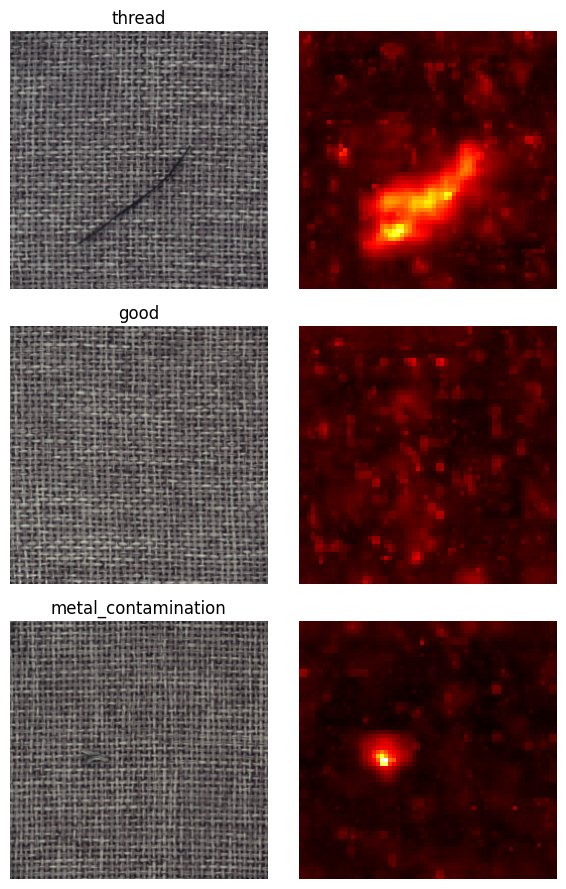

[INFO] Saved sample heatmaps PNG: results/dev/202509202201_resnet18/PaDiM/sample_heatmaps.png


In [37]:
random.seed(0)
indices = random.sample(range(len(dev_test_loader.dataset)), 3)

final_heatmaps = method_results["padim"]["final"]["heatmaps_test"]
if final_heatmaps is None:
    raise RuntimeError("PaDiM heatmaps are not available from final model.")

heatmaps = []
for idx in indices:
    hm = final_heatmaps[idx]
    if isinstance(hm, torch.Tensor):
        heatmap_np = hm.numpy()
    else:
        heatmap_np = np.asarray(hm)
    heatmaps.append((idx, heatmap_np))

vmin = min(hm.min() for _, hm in heatmaps)
vmax = max(hm.max() for _, hm in heatmaps)

fig, axes = plt.subplots(3, 2, figsize=(6, 9))
for row, (idx, heatmap) in enumerate(heatmaps):
    img, lbl = dev_test_loader.dataset[idx]
    img = inv_transform(img)
    axes[row, 0].imshow(img)
    axes[row, 0].set_title(lbl)
    axes[row, 0].axis("off")
    axes[row, 1].imshow(heatmap, cmap="hot", vmin=vmin, vmax=vmax)
    axes[row, 1].axis("off")

plt.tight_layout()
plt.show()

out_png = dir_padim / "sample_heatmaps_final.png"
fig.savefig(out_png, dpi=150)
print(f"[INFO] Saved sample heatmaps PNG: {out_png}")


TODO:run_cv_pipelineへ処理を移植（ここから）

### Thresholding (Portfolio Version)

本ノートでは、CV の Out-of-Fold (OOF) 正常スコアを結合し、その **99% 分位点**を **zスコア空間**で決めてから、全学習データで学習した **最終モデル**でも同一のパーセンタイルを保てるようにしています。

- 手順: OOF 正常スコア → μ,σ で標準化 → z=99% 分位点を閾値として保存  
- 推論: 最終モデルの学習正常スコアから μ_final, σ_final を算出 → スコアを z 化して z_threshold を適用  
- 目的: 想定 FPR≈1% を簡潔にコントロールしつつ、最終モデルへ閾値を移植しても意味が崩れにくい構成

**Future Work**
- fold アンサンブル（スコア平均/最大）で OOF と同定義を維持  
- EVT(POT) による低 FPR 領域の外挿  
- Conformal 分位点（正常のみ校正で FPR≤α を保証）  
- カテゴリ/ライン別閾値、ラベル有り時の F1/Youden/コスト最適化


注: 本処理は `run_pipeline` 内で自動実行されます。

TODO:run_cv_pipelineへ処理を移植（ここまで）

## 設定の保存
出力先：assets/fixed_pipeline.json

In [ ]:
# デフォルトではファイルを書き出さない（テンプレートのため）。
# 実際に保存したい場合は SAVE_FIXED=True にして実行してください。
SAVE_FIXED = True

fixed_pipeline = {
    "common": {
        "image_size": image_size,
        "backbone": backbone,
        "threshold_percentile": threshold_percentile
    },
    "mahalanobis": {"layer": MD_layer},
    "padim": {"layers": padim_layers, "d": padim_channel_subsample}
}

assets_dir = Path("assets")
assets_dir.mkdir(parents=True, exist_ok=True)
cfg_path = assets_dir / "fixed_pipeline.json"

if SAVE_FIXED:
    with cfg_path.open("w", encoding="utf-8") as f:
        json.dump(fixed_pipeline, f, indent=2, ensure_ascii=False)
    print(f"[INFO] Saved: {cfg_path}")
else:
    print("[INFO] SAVE_FIXED=False のため assets 固定ファイルはスキップ。")

# 必須: 実行設定を timestamp 付き出力ディレクトリにも保存
cfg_out = base_dir / 'fixed_pipeline.json'
with cfg_out.open('w', encoding='utf-8') as f:
    json.dump(fixed_pipeline, f, indent=2, ensure_ascii=False)
print(f"[INFO] Saved config to: {cfg_out}")


## 次の手順
- 上記のテンプレート関数に実装を追加し、dev の test から閾値を決めて `SAVE_FIXED=True` で JSON を保存。
- その後 `02_evaluation_report.ipynb` で eval カテゴリを一発評価。
- リーク防止のため、02 ではパラメータ・閾値を変更しないこと。
